# Posterior Predictive Checks for State Space Models

This notebook introduces **posterior predictive checks**, an advanced diagnostic that asks: "If the model were true, how likely is the observed data?" This provides a complementary view to the state-likelihood consistency checks.

**Learning objectives:**
- Understand predictive density and its computation
- Learn when to use log-space for numerical stability
- Compute posterior predictive p-values
- Interpret p-value patterns for model diagnostics
- Combine multiple diagnostic approaches

**Previous:** [03_time_resolved_diagnostics.ipynb](03_time_resolved_diagnostics.ipynb)

## Setup

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

sys.path.insert(0, str(Path.cwd().parent))

from utils import configure_notebook_plotting

from statespacecheck import (
    log_predictive_density,
    predictive_density,
    predictive_pvalue,
)

configure_notebook_plotting()

## What is Predictive Density?

**Predictive density** measures how likely the observed data is under the model's prediction:

$$p(y_t) = \int p(y_t | x_t) p(x_t | y_{1:t-1}) dx_t = \sum_x p(y_t | x_t) p(x_t)$$

**Components:**
- $p(y_t | x_t)$: Observation likelihood (how likely is this observation at each state?)
- $p(x_t)$: State distribution (what states are probable?)
- Integration: Average likelihood over all probable states

**Interpretation:**
- **High predictive density**: Data is consistent with model predictions
- **Low predictive density**: Data is surprising given the model
- Averaged over time, gives overall model fit

**Key difference from previous metrics:**
- KL/overlap: Compare distributions (state vs likelihood)
- Predictive density: Evaluate data plausibility under the model

## Computing Predictive Density

Let's start with a simple example.

Predictive density: 0.064510

Interpretation: The observed data has predictive density 0.064510
This value depends on the bin size and normalization.


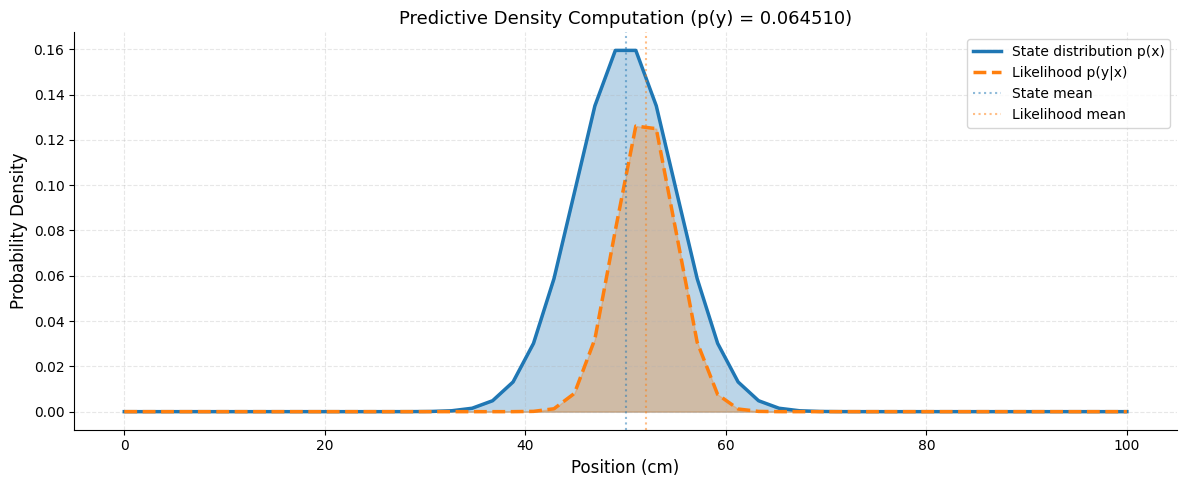

In [2]:
# Generate simple data
position_bins = np.linspace(0, 100, 50)

# State distribution: Model expects position around 50 cm
state_dist = norm.pdf(position_bins, loc=50.0, scale=5.0)
state_dist = state_dist / state_dist.sum()  # Normalize

# Likelihood: Observation suggests position around 52 cm (close to prediction)
likelihood = norm.pdf(position_bins, loc=52.0, scale=3.0)
# NOTE: likelihood is NOT normalized - it's p(y|x) evaluated at each x

# Add time dimension
state_dist_2d = state_dist[np.newaxis, :]
likelihood_2d = likelihood[np.newaxis, :]

# Compute predictive density
pred_dens = predictive_density(state_dist_2d, likelihood_2d)[0]

print(f"Predictive density: {pred_dens:.6f}")
print(f"\nInterpretation: The observed data has predictive density {pred_dens:.6f}")
print("This value depends on the bin size and normalization.")

# Visualize
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(position_bins, state_dist, linewidth=2.5, color="#1f77b4", label="State distribution p(x)")
ax.plot(
    position_bins,
    likelihood,
    linewidth=2.5,
    color="#ff7f0e",
    linestyle="--",
    label="Likelihood p(y|x)",
)
ax.fill_between(position_bins, state_dist, alpha=0.3, color="#1f77b4")
ax.fill_between(position_bins, likelihood, alpha=0.3, color="#ff7f0e")
ax.axvline(50, color="#1f77b4", linestyle=":", alpha=0.5, label="State mean")
ax.axvline(52, color="#ff7f0e", linestyle=":", alpha=0.5, label="Likelihood mean")
ax.set_xlabel("Position (cm)")
ax.set_ylabel("Probability Density")
ax.set_title(f"Predictive Density Computation (p(y) = {pred_dens:.6f})")
ax.legend(frameon=True, loc="upper right")
plt.tight_layout()
plt.show()

### Understanding the Computation

The predictive density integrates (sums) the product of:
1. **State distribution**: Probability of each position
2. **Likelihood**: How well the data fits at each position

When state and likelihood agree (both peak near the same location), predictive density is high. When they disagree, predictive density is low.

## Comparing Good vs Poor Fit

Let's compare predictive density for well-fitting vs poorly-fitting data.

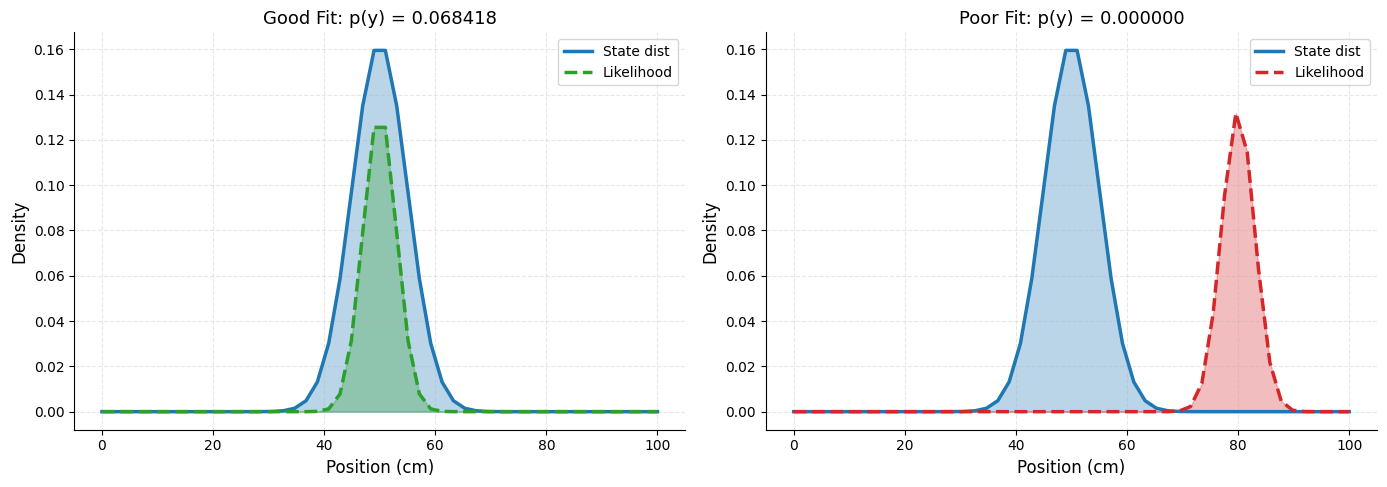

Predictive density comparison:
  Good fit: 0.068418
  Poor fit: 0.000000
  Ratio: 559777.2x higher for good fit


In [3]:
# Case 1: Good fit - likelihood agrees with state
likelihood_good = norm.pdf(position_bins, loc=50.0, scale=3.0)  # Same location as state
likelihood_good_2d = likelihood_good[np.newaxis, :]
pred_dens_good = predictive_density(state_dist_2d, likelihood_good_2d)[0]

# Case 2: Poor fit - likelihood disagrees with state
likelihood_poor = norm.pdf(position_bins, loc=80.0, scale=3.0)  # Far from state
likelihood_poor_2d = likelihood_poor[np.newaxis, :]
pred_dens_poor = predictive_density(state_dist_2d, likelihood_poor_2d)[0]

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Good fit
ax1.plot(position_bins, state_dist, linewidth=2.5, color="#1f77b4", label="State dist")
ax1.plot(
    position_bins,
    likelihood_good,
    linewidth=2.5,
    color="#2ca02c",
    linestyle="--",
    label="Likelihood",
)
ax1.fill_between(position_bins, state_dist, alpha=0.3, color="#1f77b4")
ax1.fill_between(position_bins, likelihood_good, alpha=0.3, color="#2ca02c")
ax1.set_xlabel("Position (cm)")
ax1.set_ylabel("Density")
ax1.set_title(f"Good Fit: p(y) = {pred_dens_good:.6f}")
ax1.legend(frameon=True, loc="upper right")

# Poor fit
ax2.plot(position_bins, state_dist, linewidth=2.5, color="#1f77b4", label="State dist")
ax2.plot(
    position_bins,
    likelihood_poor,
    linewidth=2.5,
    color="#d62728",
    linestyle="--",
    label="Likelihood",
)
ax2.fill_between(position_bins, state_dist, alpha=0.3, color="#1f77b4")
ax2.fill_between(position_bins, likelihood_poor, alpha=0.3, color="#d62728")
ax2.set_xlabel("Position (cm)")
ax2.set_ylabel("Density")
ax2.set_title(f"Poor Fit: p(y) = {pred_dens_poor:.6f}")
ax2.legend(frameon=True, loc="upper right")

plt.tight_layout()
plt.show()

print("Predictive density comparison:")
print(f"  Good fit: {pred_dens_good:.6f}")
print(f"  Poor fit: {pred_dens_poor:.6f}")
print(f"  Ratio: {pred_dens_good / pred_dens_poor:.1f}x higher for good fit")

The predictive density is much higher when state and likelihood agree! This quantifies how "surprising" the data is under the model.

## Log Predictive Density for Numerical Stability

For real applications with many bins or peaked distributions, predictive densities can become very small, leading to numerical underflow. We use **log-space** computation for stability.

In [4]:
# Demonstrate numerical issues with many bins
position_bins_fine = np.linspace(0, 100, 500)  # Many bins!

state_fine = norm.pdf(position_bins_fine, loc=50.0, scale=5.0)
state_fine = state_fine / state_fine.sum()
likelihood_fine = norm.pdf(position_bins_fine, loc=50.0, scale=3.0)

state_fine_2d = state_fine[np.newaxis, :]
likelihood_fine_2d = likelihood_fine[np.newaxis, :]

# Linear space computation
pred_dens_linear = predictive_density(state_fine_2d, likelihood_fine_2d)[0]

# Log space computation
log_pred_dens = log_predictive_density(state_fine_2d, likelihood=likelihood_fine_2d)[0]

print(f"Linear space: p(y) = {pred_dens_linear:.10f}")
print(f"Log space: log p(y) = {log_pred_dens:.6f}")
print(f"Verification: exp(log p(y)) = {np.exp(log_pred_dens):.10f}")
print("\nLog space is more numerically stable for small probabilities!")

Linear space: p(y) = 0.0684180366
Log space: log p(y) = -2.682119
Verification: exp(log p(y)) = 0.0684180366

Log space is more numerically stable for small probabilities!


**Why use log-space?**
- Prevents underflow for very small probabilities
- More numerically stable for optimization
- Standard practice in Bayesian inference
- Can directly use log-likelihoods without exp/log round-trip

## Posterior Predictive P-Values

A single predictive density value is hard to interpret ("Is 0.0023 good or bad?"). **Posterior predictive p-values** provide context by comparing to simulated data:

**Process:**
1. Compute predictive density for observed data
2. Generate many datasets from the model
3. Compute predictive density for each simulated dataset
4. P-value = proportion of simulated densities ≥ observed density

**Interpretation:**
- **p ≈ 0.5**: Observed data is typical for this model
- **p ≈ 0 or 1**: Observed data is extreme (model may be misspecified)
- **Systematic patterns**: Indicate model problems

### Example: Computing P-Values

Let's create a simple scenario and compute p-values.

In [5]:
# Generate time series data
np.random.seed(42)
n_time = 100

# True model: position follows Gaussian with some dynamics
true_means = 50 + 10 * np.sin(2 * np.pi * np.arange(n_time) / 50)
state_dist_seq = np.array([norm.pdf(position_bins, loc=m, scale=5.0) for m in true_means])
state_dist_seq = state_dist_seq / state_dist_seq.sum(axis=1, keepdims=True)

# Observed likelihood: mostly consistent with model
observed_likelihood = np.array(
    [norm.pdf(position_bins, loc=m + np.random.normal(0, 2), scale=3.0) for m in true_means]
)

# Compute observed log predictive density
observed_log_pred = log_predictive_density(state_dist_seq, likelihood=observed_likelihood)

print("Observed log predictive densities (first 5 time points):")
print(observed_log_pred[:5])

Observed log predictive densities (first 5 time points):
[-2.69663203 -2.68324333 -2.70679529 -2.81856703 -2.68534396]


Now let's create a sampler that generates datasets from the model and compute their predictive densities:

In [6]:
def create_sampler(state_dist_seq, true_means, position_bins):
    """Create a function that samples predictive densities from the model."""
    rng = np.random.default_rng(42)  # Fixed seed for reproducibility

    def sampler(n_samples):
        """Sample n predictive density realizations from the model."""
        log_pred_samples = np.zeros((n_samples, len(true_means)))

        for i in range(n_samples):
            # Simulate likelihood from the model
            sim_likelihood = np.array(
                [norm.pdf(position_bins, loc=m + rng.normal(0, 2), scale=3.0) for m in true_means]
            )

            # Compute predictive density for this simulation
            log_pred_samples[i] = log_predictive_density(state_dist_seq, likelihood=sim_likelihood)

        return log_pred_samples

    return sampler


# Create sampler
sampler = create_sampler(state_dist_seq, true_means, position_bins)

# Compute p-values
p_values = predictive_pvalue(observed_log_pred, sampler, n_samples=1000)

print("\nP-values (first 10 time points):")
print(p_values[:10])
print("\nP-value statistics:")
print(f"  Mean: {np.mean(p_values):.3f}")
print(f"  Std: {np.std(p_values):.3f}")
print(f"  Min: {np.min(p_values):.3f}")
print(f"  Max: {np.max(p_values):.3f}")


P-values (first 10 time points):
[0.392 0.096 0.49  0.864 0.185 0.192 0.892 0.53  0.356 0.44 ]

P-value statistics:
  Mean: 0.467
  Std: 0.278
  Min: 0.005
  Max: 0.995


For a well-specified model, p-values should be approximately uniformly distributed between 0 and 1. Let's visualize:

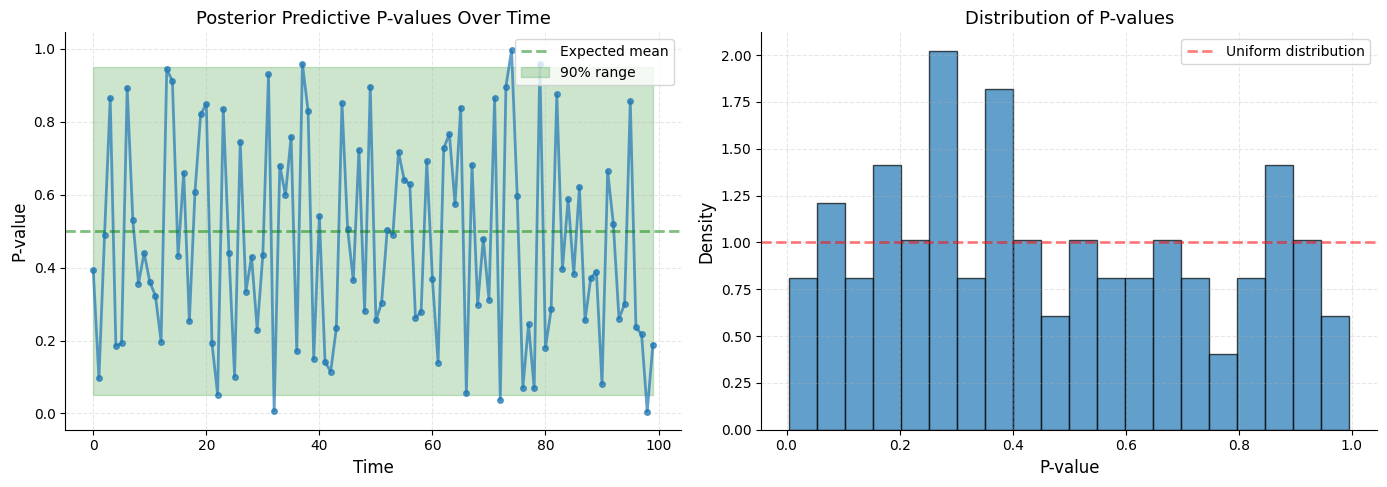

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Time series of p-values
ax1.plot(
    np.arange(n_time), p_values, linewidth=2, marker="o", markersize=4, alpha=0.7, color="#1f77b4"
)
ax1.axhline(0.5, color="green", linestyle="--", alpha=0.5, linewidth=2, label="Expected mean")
ax1.fill_between(np.arange(n_time), 0.05, 0.95, alpha=0.2, color="green", label="90% range")
ax1.set_xlabel("Time")
ax1.set_ylabel("P-value")
ax1.set_title("Posterior Predictive P-values Over Time")
ax1.legend(frameon=True, loc="upper right")
ax1.grid(True, alpha=0.3)

# Histogram of p-values
ax2.hist(p_values, bins=20, edgecolor="black", alpha=0.7, color="#1f77b4", density=True)
ax2.axhline(1.0, color="red", linestyle="--", linewidth=2, alpha=0.5, label="Uniform distribution")
ax2.set_xlabel("P-value")
ax2.set_ylabel("Density")
ax2.set_title("Distribution of P-values")
ax2.legend(frameon=True, loc="upper right")
ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

### Interpretation

**Left panel:** P-values fluctuate around 0.5, as expected for well-specified model

**Right panel:** P-values are roughly uniform (approximately equal density across range)

**What this tells us:**
- Observed data is consistent with model predictions
- No systematic deviations (no clustering near 0 or 1)
- Model appears well-calibrated

## Detecting Model Misspecification with P-Values

Now let's see what happens when the model is misspecified during a period.

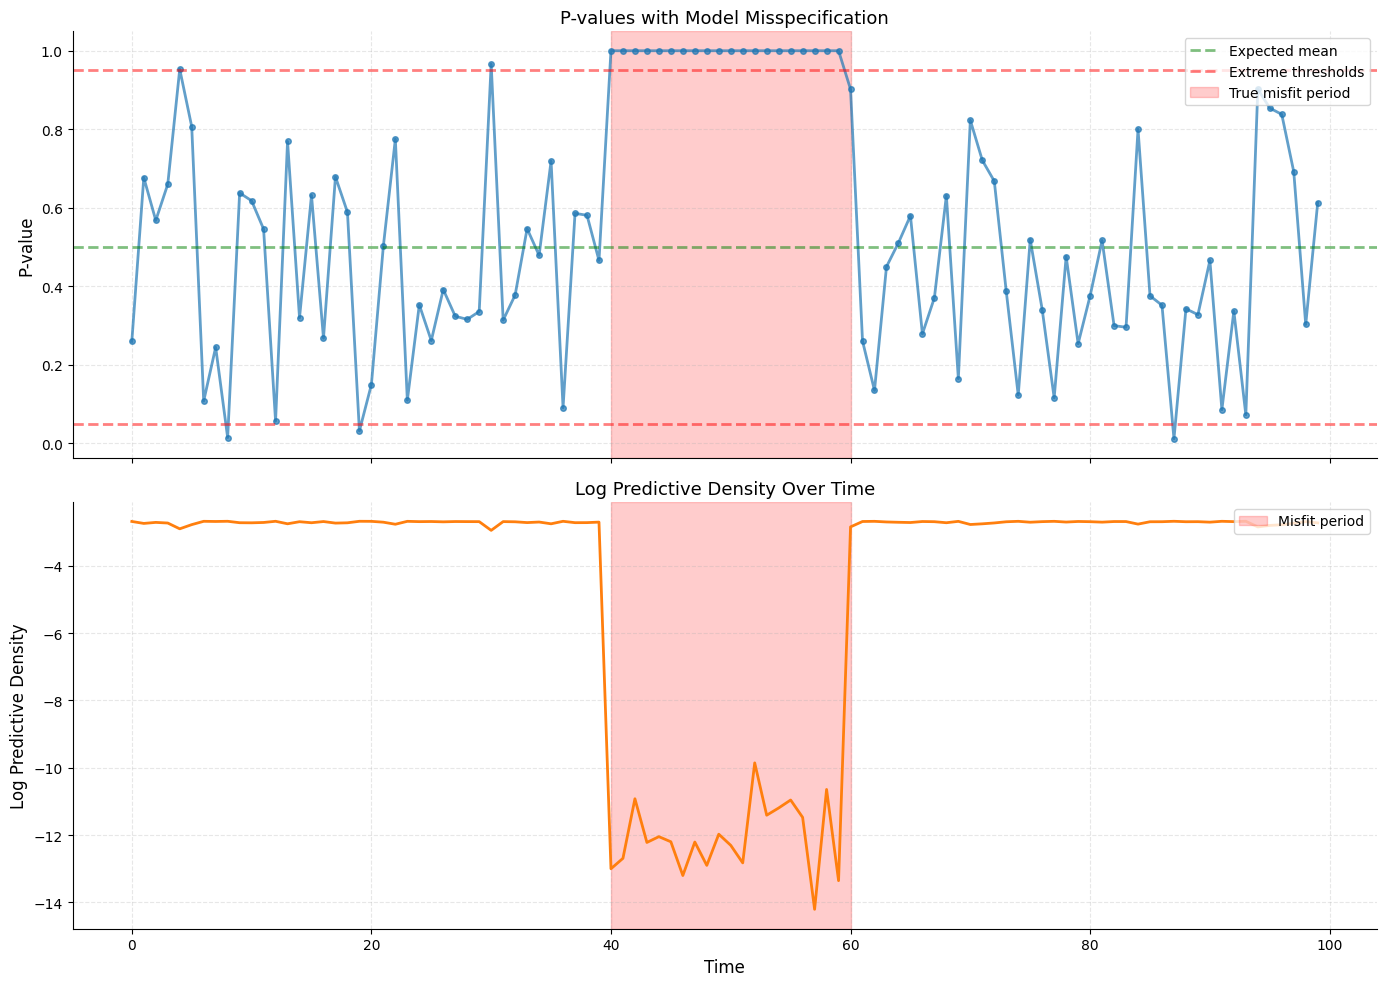

P-value statistics by period:

Period          Mean P-value % Extreme (<0.05 or >0.95)
-------------------------------------------------------
Good fit               0.446                      6.2%
Misfit                 1.000                    100.0%


In [8]:
# Create misspecified scenario: model predicts wrong location during middle period
n_time = 100
misfit_start = 40
misfit_end = 60

# State distribution: model's prediction
model_means = 50 + 10 * np.sin(2 * np.pi * np.arange(n_time) / 50)
state_dist_misspec = np.array([norm.pdf(position_bins, loc=m, scale=5.0) for m in model_means])
state_dist_misspec = state_dist_misspec / state_dist_misspec.sum(axis=1, keepdims=True)

# Observed data: matches model except during misfit period
rng = np.random.default_rng(42)
observed_means = model_means.copy()
observed_means[misfit_start:misfit_end] += 25  # Large offset during misfit period!

observed_like_misspec = np.array(
    [norm.pdf(position_bins, loc=m + rng.normal(0, 2), scale=3.0) for m in observed_means]
)

# Compute observed log predictive density
observed_log_pred_misspec = log_predictive_density(
    state_dist_misspec, likelihood=observed_like_misspec
)

# Create sampler (using correct model means, not observed)
sampler_misspec = create_sampler(state_dist_misspec, model_means, position_bins)

# Compute p-values
p_values_misspec = predictive_pvalue(observed_log_pred_misspec, sampler_misspec, n_samples=1000)

# Visualize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# P-values over time
ax1.plot(
    np.arange(n_time),
    p_values_misspec,
    linewidth=2,
    marker="o",
    markersize=4,
    alpha=0.7,
    color="#1f77b4",
)
ax1.axhline(0.5, color="green", linestyle="--", alpha=0.5, linewidth=2, label="Expected mean")
ax1.axhline(0.05, color="red", linestyle="--", alpha=0.5, linewidth=2, label="Extreme thresholds")
ax1.axhline(0.95, color="red", linestyle="--", alpha=0.5, linewidth=2)
ax1.axvspan(misfit_start, misfit_end, alpha=0.2, color="red", label="True misfit period")
ax1.set_ylabel("P-value")
ax1.set_title("P-values with Model Misspecification")
ax1.legend(frameon=True, loc="upper right")
ax1.grid(True, alpha=0.3)

# Log predictive density over time
ax2.plot(np.arange(n_time), observed_log_pred_misspec, linewidth=2, color="#ff7f0e")
ax2.axvspan(misfit_start, misfit_end, alpha=0.2, color="red", label="Misfit period")
ax2.set_xlabel("Time")
ax2.set_ylabel("Log Predictive Density")
ax2.set_title("Log Predictive Density Over Time")
ax2.legend(frameon=True, loc="upper right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("P-value statistics by period:")
print(f"\n{'Period':<15} {'Mean P-value':>12} {'% Extreme (<0.05 or >0.95)':>25}")
print("-" * 55)
good_pvals = p_values_misspec[
    np.concatenate([np.arange(misfit_start), np.arange(misfit_end, n_time)])
]
bad_pvals = p_values_misspec[misfit_start:misfit_end]
print(
    f"{'Good fit':<15} {np.mean(good_pvals):>12.3f} {((good_pvals < 0.05) | (good_pvals > 0.95)).sum() / len(good_pvals) * 100:>24.1f}%"
)
print(
    f"{'Misfit':<15} {np.mean(bad_pvals):>12.3f} {((bad_pvals < 0.05) | (bad_pvals > 0.95)).sum() / len(bad_pvals) * 100:>24.1f}%"
)

### Interpretation

**Key observations:**
- **P-values drop dramatically** during misfit period (many near 0)
- **Log predictive density decreases** during misfit (data is surprising)
- **Good periods** have p-values scattered around 0.5
- **Misfit periods** have extreme p-values (data very unlikely under model)

**Why p-values near 0?**
- Observed log predictive density is much lower than typical simulations
- Most simulated datasets are more consistent with model than observed data
- This indicates model fails to capture the data during that period

## Combining Multiple Diagnostics

Let's bring everything together: KL divergence, HPD overlap, and predictive p-values provide complementary views of model fit.

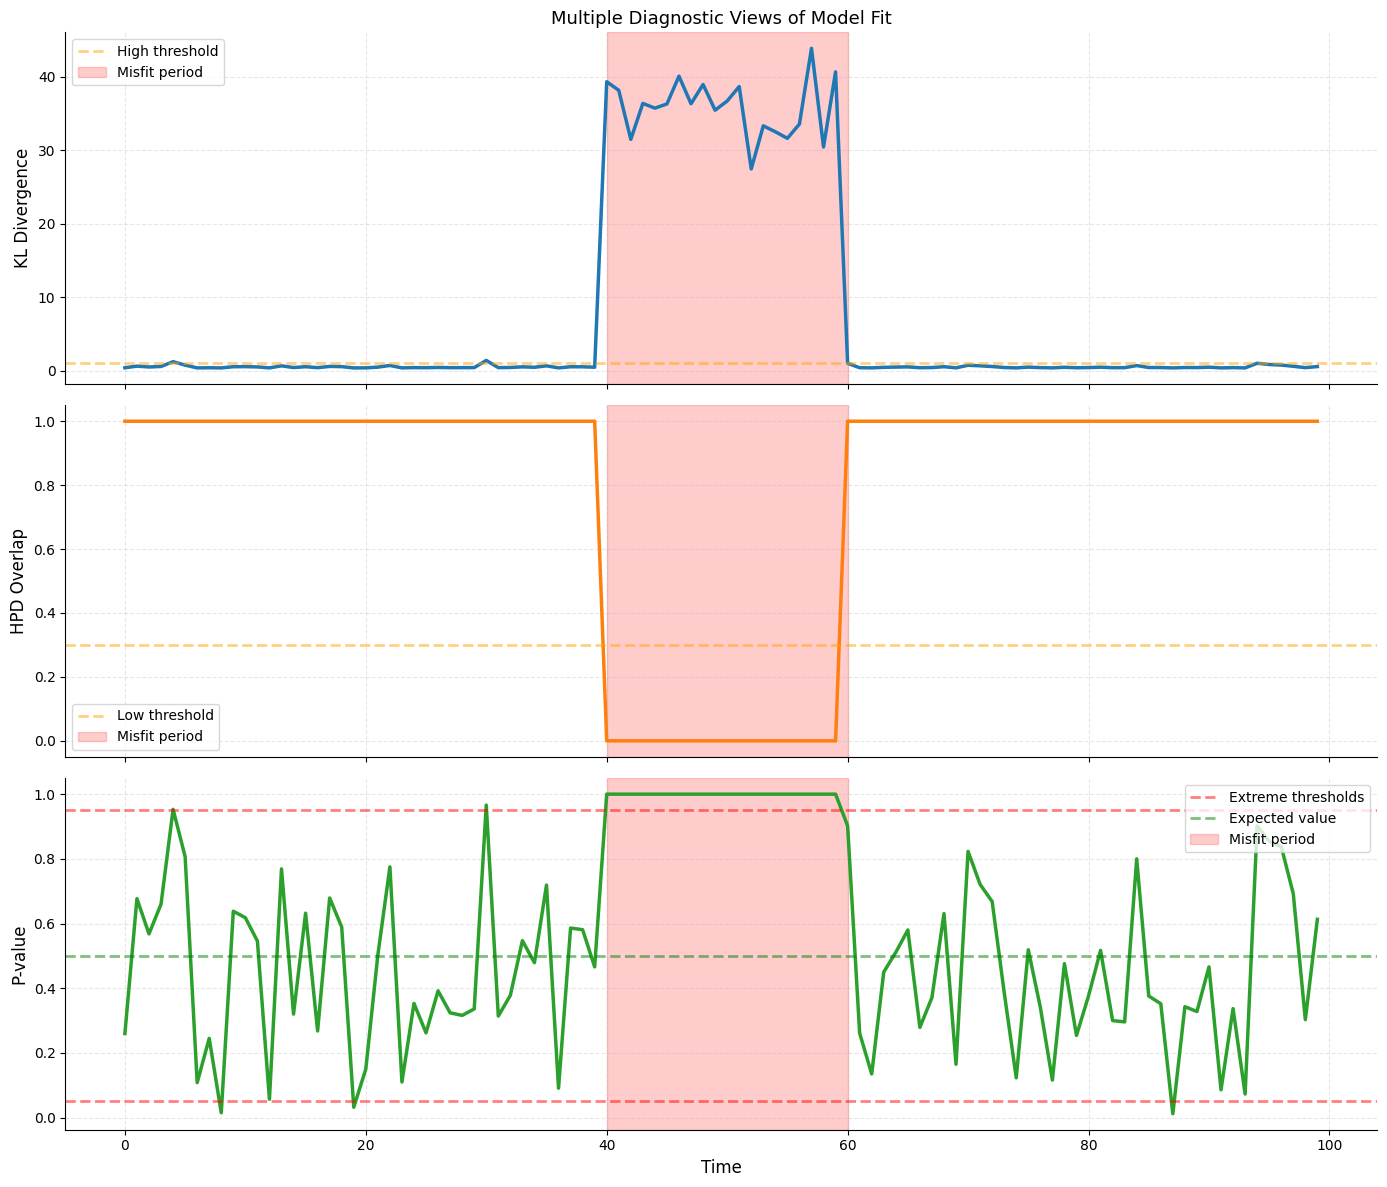

In [9]:
from statespacecheck import hpd_overlap, kl_divergence

# Compute all diagnostics for the misspecified case
kl_div_misspec = kl_divergence(state_dist_misspec, observed_like_misspec)
overlap_misspec = hpd_overlap(state_dist_misspec, observed_like_misspec, coverage=0.95)

# Visualize all three together
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# KL divergence
ax1.plot(np.arange(n_time), kl_div_misspec, linewidth=2.5, color="#1f77b4")
ax1.axhline(1.0, color="orange", linestyle="--", alpha=0.5, linewidth=2, label="High threshold")
ax1.axvspan(misfit_start, misfit_end, alpha=0.2, color="red", label="Misfit period")
ax1.set_ylabel("KL Divergence")
ax1.set_title("Multiple Diagnostic Views of Model Fit")
ax1.legend(frameon=True, loc="upper left")
ax1.grid(True, alpha=0.3)

# HPD overlap
ax2.plot(np.arange(n_time), overlap_misspec, linewidth=2.5, color="#ff7f0e")
ax2.axhline(0.3, color="orange", linestyle="--", alpha=0.5, linewidth=2, label="Low threshold")
ax2.axvspan(misfit_start, misfit_end, alpha=0.2, color="red", label="Misfit period")
ax2.set_ylabel("HPD Overlap")
ax2.legend(frameon=True, loc="lower left")
ax2.grid(True, alpha=0.3)

# P-values
ax3.plot(np.arange(n_time), p_values_misspec, linewidth=2.5, color="#2ca02c")
ax3.axhline(0.05, color="red", linestyle="--", alpha=0.5, linewidth=2, label="Extreme thresholds")
ax3.axhline(0.95, color="red", linestyle="--", alpha=0.5, linewidth=2)
ax3.axhline(0.5, color="green", linestyle="--", alpha=0.5, linewidth=2, label="Expected value")
ax3.axvspan(misfit_start, misfit_end, alpha=0.2, color="red", label="Misfit period")
ax3.set_xlabel("Time")
ax3.set_ylabel("P-value")
ax3.legend(frameon=True, loc="upper right")
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Complementary Information

Each diagnostic provides a different perspective:

**KL Divergence:**
- Measures distribution disagreement
- Spikes when state and likelihood concentrate mass differently
- Sensitive to shape differences

**HPD Overlap:**
- Measures spatial consistency
- Drops when high-density regions don't align
- Intuitive spatial interpretation

**P-values:**
- Compares observed to expected under model
- Detects when data is surprising/extreme
- Requires simulation but provides calibrated interpretation

**All three agree:** The misfit period is clearly problematic!

## Practical Workflow for Your Data

Here's a recommended workflow for applying these diagnostics to real state space models:

### 1. Compute Basic Diagnostics
```python
kl_div = kl_divergence(state_dist, likelihood)
overlap = hpd_overlap(state_dist, likelihood, coverage=0.95)
```

### 2. Visualize Over Time
```python
plt.plot(time, kl_div)
plt.plot(time, overlap)
```

### 3. Flag Problematic Periods
```python
from statespacecheck import flag_extreme_kl, flag_low_overlap
kl_flags = flag_extreme_kl(kl_div, threshold=1.0)
overlap_flags = flag_low_overlap(overlap, threshold=0.3)
```

### 4. If Issues Detected, Compute P-values
```python
log_pred = log_predictive_density(state_dist, likelihood=likelihood)
# Create sampler based on your model
p_vals = predictive_pvalue(log_pred, sampler, n_samples=1000)
```

### 5. Interpret Results
- Multiple metrics agree → Strong evidence of problem
- Only one metric flags → Investigate further
- P-values systematically extreme → Model misspecification
- All metrics good → Model fits well!

## Summary: What We Learned

**Core concepts:**
- **Predictive density**: How likely is observed data under the model?
- **Log-space**: Use `log_predictive_density()` for numerical stability
- **P-values**: Compare observed to simulated data for calibrated interpretation

**Key functions:**
- `predictive_density()`: Compute p(y) = ∫ p(y|x) p(x) dx
- `log_predictive_density()`: Compute in log-space for stability
- `predictive_pvalue()`: Monte Carlo p-values via simulation

**Practical insights:**
- Predictive checks complement distribution comparison metrics
- P-values near 0 or 1 indicate model problems
- Log-space is essential for realistic applications
- Multiple diagnostics provide robustness

**Complete diagnostic toolkit:**
1. **KL divergence**: Distribution disagreement
2. **HPD overlap**: Spatial consistency
3. **Predictive p-values**: Data plausibility
4. **Time-resolved analysis**: Identify when/where models fail

**Neuroscience applications:**
- Validate neural decoding models
- Compare different state space architectures
- Identify behavioral epochs where models break down
- Calibrate uncertainty estimates

**You're now equipped** to thoroughly diagnose state space models!

## Exercises (Optional)

1. What happens to p-values if you use too few simulation samples (e.g., n_samples=10)?
2. Create a case where KL divergence is high but p-values are moderate. What does this tell you?
3. How would you use predictive checks to compare two different model architectures?
4. Can you detect the difference between systematic bias and random noise using these diagnostics?